# Field Failure Data Analysis

## Introduction

In [1]:
# Import relevant modules
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from reliability.Fitters import Fit_Everything, Fit_Weibull_3P
from reliability.Reliability_testing import KStest
from reliability.Distributions import Weibull_Distribution
from reliability.Probability_plotting import plot_points
from statsmodels.distributions.empirical_distribution import ECDF

# %matplotlib notebook
# from IPython.core.interactiveshell import InteractiveShell

## Utility functions

In [2]:
def sensitivity_analysis(dataframe, c_wins, filepath):
    if(not os.path.isfile(filepath)):
        print('Creating file',filepath, 'this may take a while...\n')
        tuples = []

        for win in c_wins:
            tup = 1
            prev = int(dataframe.loc[0,'Timestamp'])

            for index in range(dataframe.shape[0]-1):
                succ = int(dataframe.loc[index+1,'Timestamp'])
                if  succ - prev >= win:
                    tup = tup + 1
                prev = succ

#             print(str(win)+' '+str(tup))    
            tuples.append(tup)
        
        sens_file = open(filepath, 'w')
        
        for i in range(len(c_wins)):
            sens_file.write(str(c_wins[i]) + ' ' + str(tuples[i]) + '\n')
        
        sens_file.close()
    else:
        print('File already exists!\n')

In [3]:
def tupling(dataframe, c_win, filepath):
    if(not os.path.isfile(filepath)):
        print('Creating file', filepath, 'this may take a while...\n')
        
        tup = 0
        prev = int(dataframe.loc[0,'Timestamp'])
        dataframe.loc[0,'Tuple'] = 0

        for index in range(dataframe.shape[0]-1):
            succ = int(dataframe.loc[index+1,'Timestamp'])
            if  succ - prev >= c_win:
                tup = tup + 1
            dataframe.loc[index+1,'Tuple'] = tup
            prev = succ
            
        dataframe.to_csv(filepath)
        return dataframe
    else:
        print('File already exists!\n')
        dataframe = pd.read_csv(filepath, index_col = 0)
        return dataframe

In [4]:
def statistics(dataframe):
    df_stat = pd.DataFrame(columns=['# Entries', 'Start time', 'End time', 'Length', 'Density', 'Interarrival'])

    df_stat['# Entries'] = dataframe.groupby(by='Tuple').count()['Timestamp']
    df_stat['Start time'] =  dataframe.groupby(by='Tuple').min(numeric_only = True)['Timestamp']
    df_stat['End time'] =  dataframe.groupby(by='Tuple').max(numeric_only = True)['Timestamp']
    df_stat['Length'] =  df_stat['End time'] - df_stat['Start time']
    df_stat['Density'] = df_stat['# Entries'] / df_stat['Length']
    df_temp = pd.DataFrame(data = {'Start time' : [np.nan]})
    df_temp = df_temp.append(df_stat, ignore_index = True)
    df_stat['Interarrival'] = (df_stat['Start time'] - df_temp['End time']).dropna().astype(int)
        
    return df_stat

# Mercury

In [5]:
# Load Mercury Data
df_mercury = pd.read_csv('Dataset/MercuryErrorLog.txt', names = ['Timestamp', 'Node', 'Subsystem', 'Message'])

df_mercury.loc[:,'Node'] = df_mercury.loc[:,'Timestamp'].str.split(' ', n=3).str[1]
df_mercury.loc[:,'Subsystem'] = df_mercury.loc[:,'Timestamp'].str.split(' ', n=3).str[2]
df_mercury.loc[:,'Message'] = df_mercury.loc[:,'Timestamp'].str.split(' ', n=3).str[3]
df_mercury.loc[:,'Timestamp'] = df_mercury.loc[:,'Timestamp'].str.split(' ', n=3).str[0]

print('Log file has ' + str(df_mercury.shape[0]) + ' entries and ' + str(df_mercury.shape[1]) + ' columns.')
df_mercury.head()

Log file has 80854 entries and 4 columns.


,Timestamp,Node,Subsystem,Message
0,1167637660,tg-c645,PRO,+BEGIN HARDWARE ERROR STATE AT CMC
1,1167637660,tg-c645,PRO,Device Error Info Section
2,1167637660,tg-c645,PRO,Error Map: x
3,1167637720,tg-c645,PRO,+BEGIN HARDWARE ERROR STATE AT CMC
4,1167637720,tg-c645,PRO,Device Error Info Section


## Data Manipulation

### Temporal coalescence

#### Sensitivity analysis

File already exists!



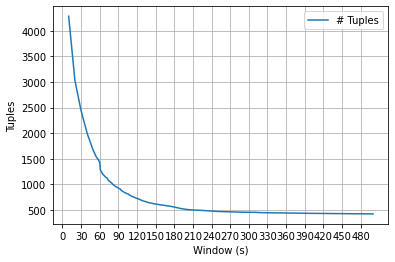

In [6]:
c_wins = np.arange(10,510,10)
accuracy = np.arange(50,150,1)
c_wins = c_wins.tolist()
c_wins.extend(accuracy)
c_wins.sort()

filepath = 'Dataset/MercurySensitivity.txt'
sensitivity_analysis(df_mercury, c_wins, filepath)

df_mercury_sensitivity = pd.read_csv(filepath, sep = ' ', names = ['Window', 'Tuples'])

plt.plot(df_mercury_sensitivity['Window'],df_mercury_sensitivity['Tuples'], label = '# Tuples')
plt.xticks(np.arange(0, 500, step = 30))
plt.xlabel('Window (s)')
plt.ylabel('Tuples')
plt.legend()
plt.grid()

File already exists!



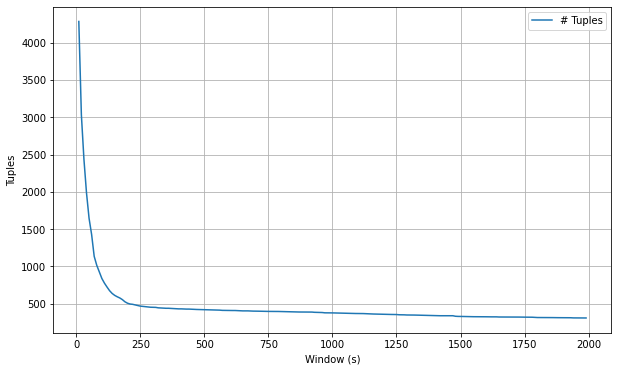

In [7]:
c_wins = np.arange(1,2000,10)

filepath = 'Dataset/MercurySensitivityAcc.txt'
sensitivity_analysis(df_mercury, c_wins, filepath)

df_mercury_sensitivity = pd.read_csv(filepath, sep = ' ', names = ['Window', 'Tuples'])

plt.figure(figsize=(10,6))

plt.plot(df_mercury_sensitivity['Window'],df_mercury_sensitivity['Tuples'], label = '# Tuples')

plt.xlabel('Window (s)')
plt.ylabel('Tuples')
plt.legend()
plt.grid()

#### Tupling

In [8]:
window = 250
filepath = 'Dataset/MercuryData.csv'
df_mercury = tupling(df_mercury, window, filepath)

df_mercury = df_mercury.astype({'Timestamp' : 'int32', 'Tuple' : 'int32'})

df_mercury.head()

File already exists!



,Timestamp,Node,Subsystem,Message,Tuple
0,1167637660,tg-c645,PRO,+BEGIN HARDWARE ERROR STATE AT CMC,0
1,1167637660,tg-c645,PRO,Device Error Info Section,0
2,1167637660,tg-c645,PRO,Error Map: x,0
3,1167637720,tg-c645,PRO,+BEGIN HARDWARE ERROR STATE AT CMC,0
4,1167637720,tg-c645,PRO,Device Error Info Section,0


In [9]:
num_tuple = df_mercury.max(axis = 0).loc['Tuple'] + 1
print('Number of tuples: ', num_tuple)

Number of tuples:  469


In [10]:
df_stat = statistics(df_mercury)
df_stat.head()

,# Entries,Start time,End time,Length,Density,Interarrival
Tuple,,,,,,
0,6,1167637660,1167637720,60,0.100000,NaN
1,3,1167655228,1167655229,1,3.000000,17508.0
2,75,1167657137,1167657550,413,0.181598,1908.0
3,2,1167657941,1167657941,0,inf,391.0
4,27,1167658201,1167658456,255,0.105882,260.0


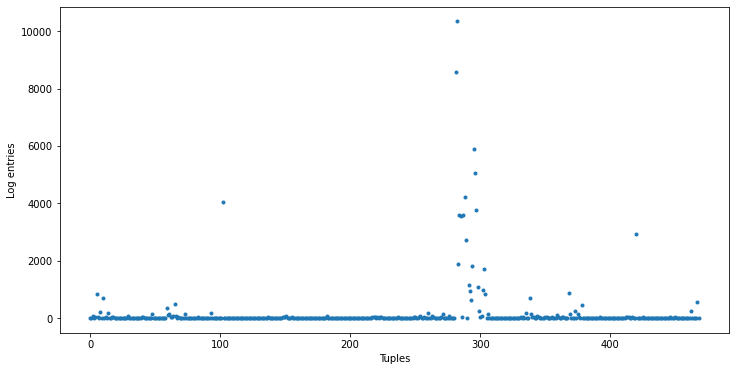

In [11]:
x = df_stat.index
y = df_stat['# Entries']

plt.figure(figsize=(12,6))

plt.scatter(x, y, marker = '.')

plt.xlabel('Tuples')
plt.ylabel('Log entries')
plt.show()

### Spatial coalescence

In [12]:
df_mercury.loc[df_mercury['Node'].str.contains('login'), 'Type'] = 'login'
df_mercury.loc[df_mercury['Node'].str.contains('c'), 'Type'] = 'computation'
df_mercury.loc[df_mercury['Node'].str.contains('s'), 'Type'] = 'storage'
df_mercury.loc[df_mercury['Node'].str.contains('master'), 'Type'] = 'master'

In [13]:
print('Number of nodes that generates error: ' + str(len(df_mercury['Node'].unique())))

Number of nodes that generates error: 53


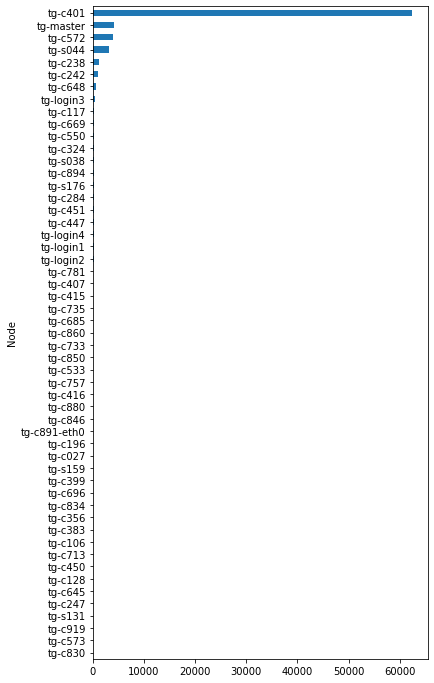

In [14]:
plt.figure(figsize=(6,12))
df_mercury.groupby(by='Node').Timestamp.count().sort_values().plot.barh()
plt.show()

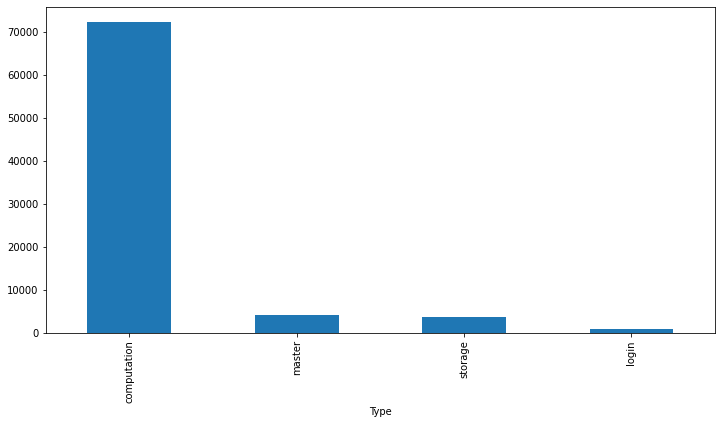

In [15]:
plt.figure(figsize=(12,6))
df_mercury.groupby(by=['Type']).Timestamp.count().sort_values(ascending = False).plot.bar()
plt.show()

### Content-based coalescence

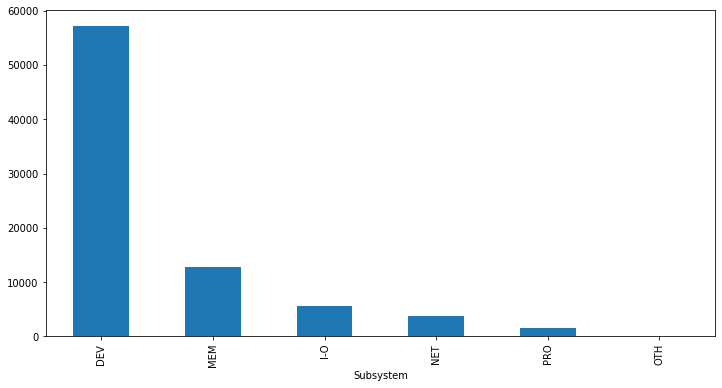

In [16]:
plt.figure(figsize=(12,6))
df_mercury.groupby(by=['Subsystem']).Timestamp.count().sort_values(ascending = False).plot.bar()
plt.show()

### Truncation analysis

In [17]:
q = df_stat['Interarrival'].quantile(q=0.1)
print("0.1 quantile: " + str(q))

0.1 quantile: 491.90000000000003


In [18]:
df_trunc = df_stat.loc[df_stat['Interarrival'] <= q]

df_trunc.head()

,# Entries,Start time,End time,Length,Density,Interarrival
Tuple,,,,,,
3,2,1167657941,1167657941,0,inf,391.0
4,27,1167658201,1167658456,255,0.105882,260.0
5,825,1167658913,1167665307,6394,0.129027,457.0
6,22,1167665787,1167665982,195,0.112821,480.0
9,17,1167669001,1167669463,462,0.036797,377.0


In [19]:
num_trunc = df_trunc.shape[0]
perc_trunc = (num_trunc/num_tuple)*100
print('Estimate number of truncations:', num_trunc)
print('Estimate percentage of truncations:', perc_trunc)

Estimate number of truncations: 47
Estimate percentage of truncations: 10.021321961620469


In [20]:
df_group = df_mercury.groupby(by=['Tuple','Node']).count()

df_group.tail()

Timestamp  Subsystem  Message  Type
Tuple Node                                          
466   tg-master          4          4        4     4
467   tg-c128            2          2        2     2
      tg-c196            2          2        2     2
      tg-master        558        558      558   558
468   tg-c196            2          2        2     2

In [21]:
df_group = df_group.reset_index(level = 1)

truncated = 0
for tup in df_trunc.index:

    df_tup = df_group.loc[df_group.index == tup]    
    node = df_tup.loc[df_tup['Timestamp'] == df_tup.max()['Timestamp'], 'Node'].item()
    
    df_tup_prec = df_group.loc[df_group.index == tup-1]
    node_prec = df_tup_prec.loc[df_tup_prec['Timestamp'] == df_tup_prec.max()['Timestamp'], 'Node'].item()
    
    if node == node_prec:
        truncated = truncated +1

In [22]:
perc_trunc = (truncated/num_tuple)*100
print('Estimate number of truncations:', truncated)
print('Estimate percentage of truncations:', perc_trunc)

Estimate number of truncations: 38
Estimate percentage of truncations: 8.102345415778252


### Collision analysis

In [23]:
collided = 0
for tup in df_group.index.unique():
    if df_group.loc[df_group.index == tup].shape[0] > 1:
        collided = collided + 1

In [24]:
perc_coll = (collided/num_tuple)*100
print('Estimate number of collisions:', collided)
print('Estimate percentage of collisions: ', perc_coll)

Estimate number of collisions: 51
Estimate percentage of collisions:  10.874200426439232


## Data analysis

### Empirical Time to failure distribution

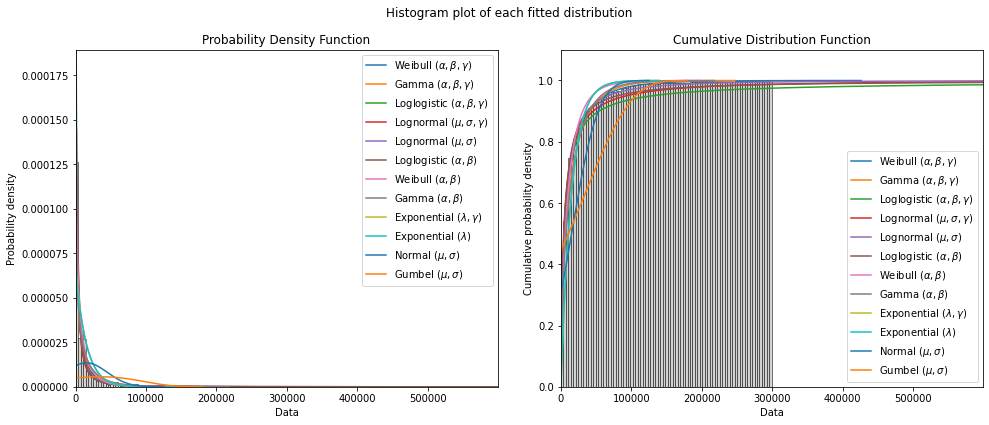

The best fitting distribution was Weibull_3P which had parameters [9.30684336e+03 5.80580908e-01 2.52999900e+02]


In [25]:
data = df_stat['Interarrival'].dropna().to_numpy()

results = Fit_Everything(failures=data, show_PP_plot = False, show_probability_plot = False, print_results = False, show_histogram_plot = True) 
print('The best fitting distribution was', results.best_distribution_name, 'which had parameters', results.best_distribution.parameters)

In [26]:
results.results

,Alpha,Beta,Gamma,Mu,Sigma,Lambda,AICc,BIC,AD
Distribution,,,,,,,,,
Weibull_3P,9306.84,0.580581,253,,,,9621.937663,9634.331344,0.781407
Gamma_3P,33518.5,0.446207,253,,,,9648.930935,9661.324616,3.413044
Loglogistic_3P,4136.65,0.854912,253,,,,9664.960542,9677.354223,2.939155
Lognormal_3P,,,235.79,8.23439,1.94723,,9665.315113,9677.708794,3.121882
Lognormal_2P,,,,8.46357,1.61232,,9701.159540,9709.430670,2.680266
Loglogistic_2P,4738.95,1.04178,,,,,9732.209731,9740.480861,3.557992
Weibull_2P,10213.1,0.748365,,,,,9776.423817,9784.694947,6.794443
Gamma_2P,28241.9,0.538533,,,,,9797.951246,9806.222376,9.079964
Exponential_2P,,,252.999,,,6.68621e-05,9937.680059,9945.951189,78.956474


Results from Fit_Weibull_3P (95% CI):
           Point Estimate  Standard Error     Lower CI      Upper CI
Parameter                                                           
Alpha         9306.843358      781.146430  7895.123887  10970.991022
Beta             0.580581        0.020628     0.541527      0.622452
Gamma          252.999900        0.000154   252.999598    253.000202
Log-Likelihood: -4807.94296952023 



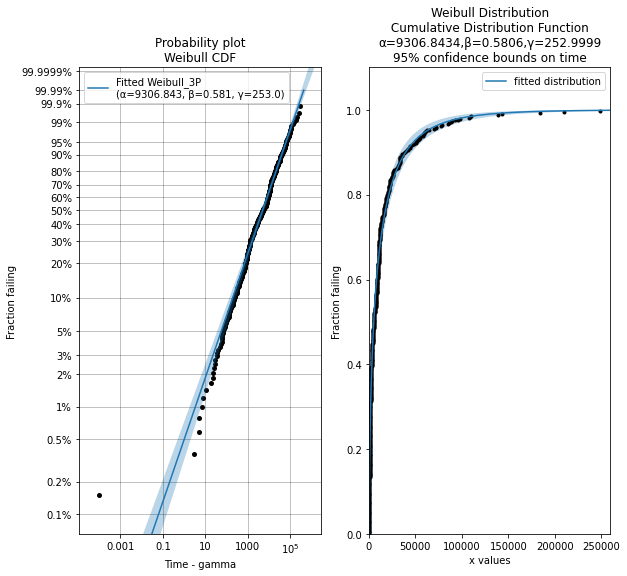

In [27]:
alpha = results.results.loc['Weibull_3P','Alpha']
beta = results.results.loc['Weibull_3P','Beta']
gamma = results.results.loc['Weibull_3P','Gamma']

plt.subplot(121)
fit = Fit_Weibull_3P(failures=data)
plt.subplot(122)
fit.distribution.CDF(label='fitted distribution')
plot_points(failures=data, func='CDF')

plt.legend()
plt.show()

Kolmogorov-Smirnov statistic: 0.03571182296387798
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can ACCEPT the hypothesis that the data comes from a Weibull Distribution (α=9306.8434,β=0.5806,γ=252.9999)


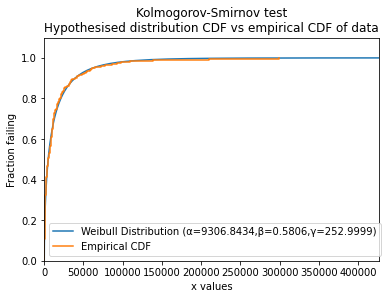

In [28]:
dist = Weibull_Distribution(alpha=alpha, beta=beta, gamma=gamma)

result = KStest(distribution = dist, data = df_stat['Interarrival'].to_numpy(), significance = 0.05)

### Empirical reliability

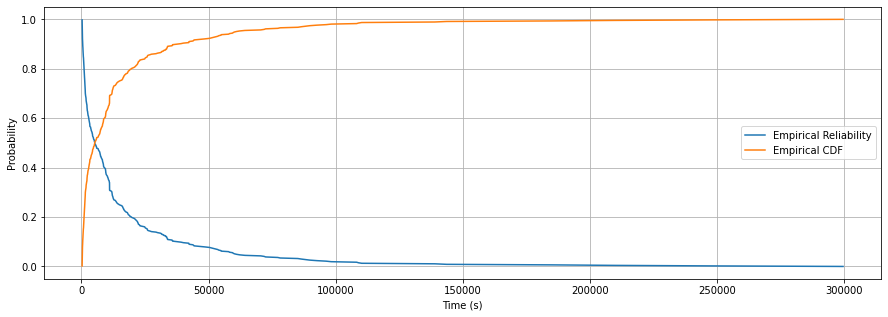

In [29]:
ecdf = ECDF(data)

plt.figure(figsize=(15,5))
    
plt.plot(ecdf.x, 1-ecdf.y, label = 'Empirical Reliability')
plt.plot(ecdf.x, ecdf.y, label = 'Empirical CDF')

plt.xlabel('Time (s)')
plt.ylabel('Probability')
plt.legend()
plt.grid()

## Node analysis

In [30]:
top_5 = df_mercury.groupby(by='Node').Timestamp.count().sort_values(ascending = False)[0:5]
top_5

Node
tg-c401      62340
tg-master     4098
tg-c572       4030
tg-s044       3224
tg-c238       1273
Name: Timestamp, dtype: int64

### Sensitivity analysis

In [31]:
c_wins = np.arange(1,500,1)

for node in top_5.index:
    df_temp = df_mercury.loc[df_mercury['Node'] == node]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = 'Dataset/Mercury-' + node + '-Sensitivity.txt'
    sensitivity_analysis(df_temp, c_wins, filepath)

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!



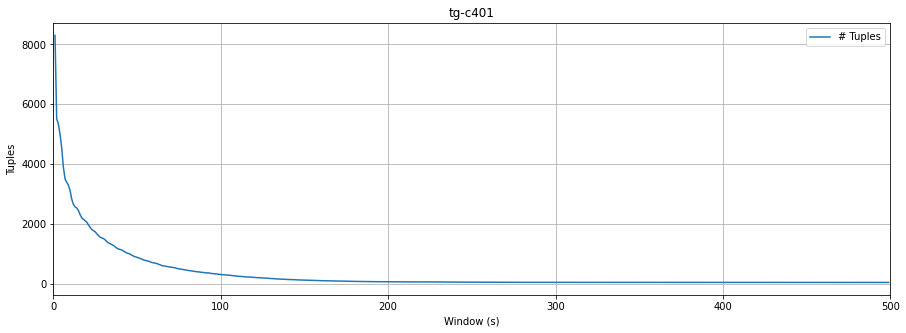

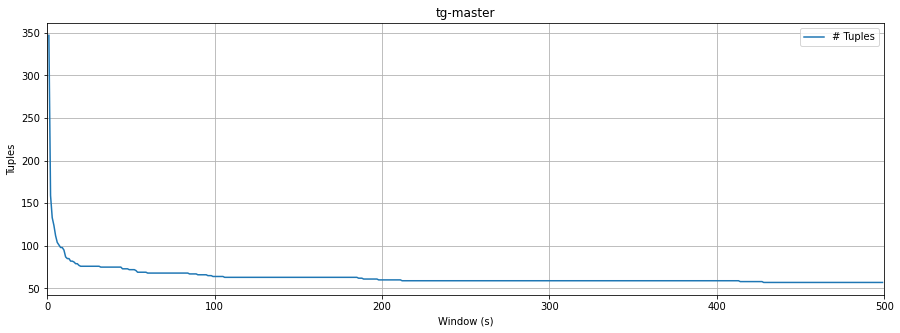

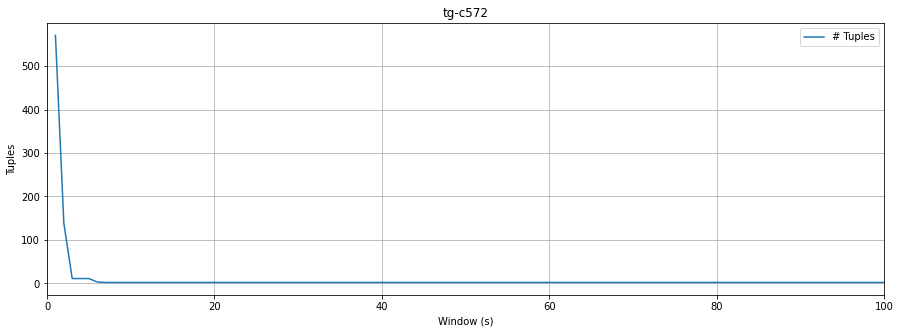

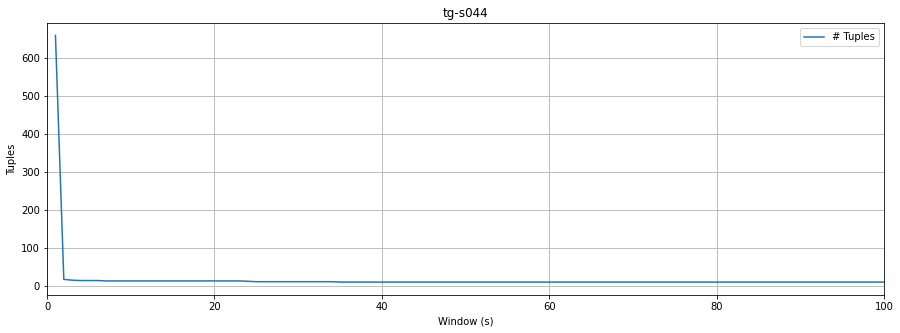

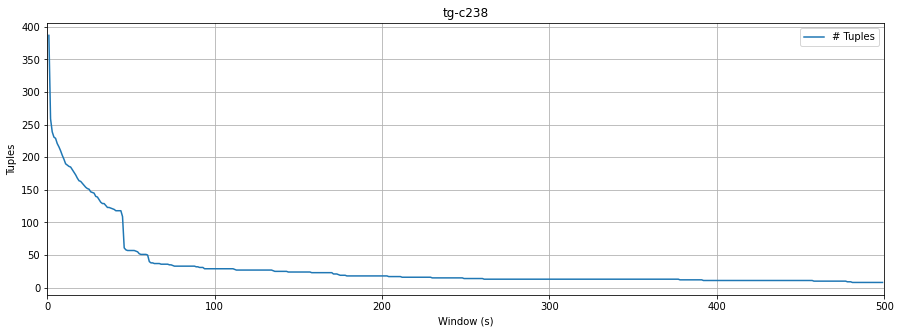

In [32]:
x_dict = {'tg-c401' : 500,
          'tg-master' : 500,
          'tg-c572' : 100,
          'tg-s044' : 100,
          'tg-c238' : 500}

for node in top_5.index:
    filepath = 'Dataset/Mercury-' + node + '-Sensitivity.txt'
    df_temp_sensitivity = pd.read_csv(filepath, sep = ' ', names = ['Window', 'Tuples'])
    
    x = df_temp_sensitivity['Window']
    y = df_temp_sensitivity['Tuples']
    
    
    plt.figure(figsize=(15,5))
    plt.plot(x, y, label = '# Tuples')
    plt.title(node)
    plt.xlim(0,x_dict[node])
#     plt.xticks(np.arange(0, 2000, step = 50))
    plt.xlabel('Window (s)')
    plt.ylabel('Tuples')
    plt.legend()
    plt.grid()

In [33]:
win_dict = {'tg-c401' : 200,
          'tg-master' : 200,
          'tg-c572' : 20,
          'tg-s044' : 30,
          'tg-c238' : 200}

print('Selected colalescence windows:', win_dict)

Selected colalescence windows: {'tg-c401': 200, 'tg-master': 200, 'tg-c572': 20, 'tg-s044': 30, 'tg-c238': 200}


### Tupling 

In [34]:
dict_df_stat = {}
dict_num_tup = {}

for node in top_5.index:
    df_temp = df_mercury.loc[df_mercury['Node'] == node]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = 'Dataset/Mercury-' + node + '-Data.txt'
    df_tupling = tupling(df_temp, win_dict[node], filepath)
    num_tup = df_tupling.max(axis = 0).loc['Tuple'] + 1
    dict_num_tup[node] = num_tup
    
    df_stat = statistics(df_tupling)
    dict_df_stat[node] = df_stat

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!



In [35]:
print('Number of tuples:', dict_num_tup)

Number of tuples: {'tg-c401': 59, 'tg-master': 60, 'tg-c572': 2, 'tg-s044': 11, 'tg-c238': 18}


### Empirical reliability

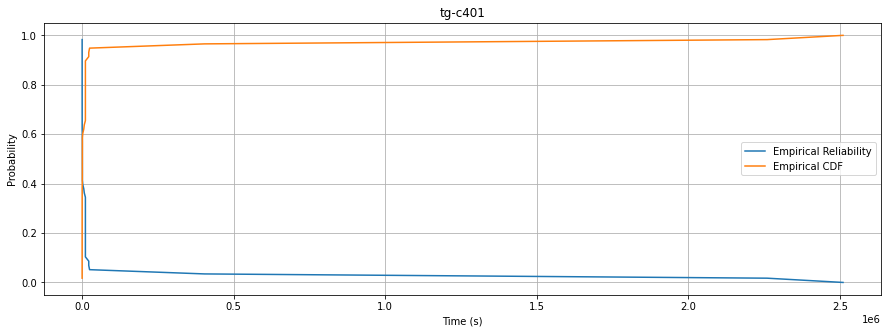

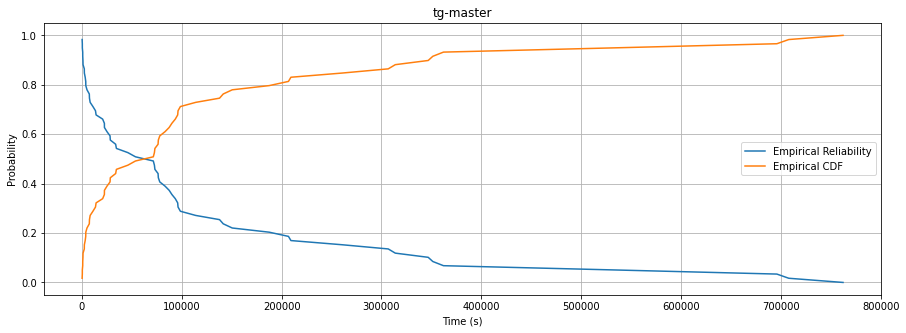

In [36]:
top_2 = [k for k in dict_num_tup if dict_num_tup[k] > 30]
for node in top_2:
    
    ecdf = ECDF(dict_df_stat[node]['Interarrival'].dropna())

    plt.figure(figsize=(15,5))
    
    plt.plot(ecdf.x, 1-ecdf.y, label = 'Empirical Reliability')
    plt.plot(ecdf.x, ecdf.y, label = 'Empirical CDF')
    plt.title(node)

    plt.xlabel('Time (s)')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid()

## Category analysis

In [45]:
categories = df_mercury.groupby(by=['Subsystem']).Timestamp.count().sort_values(ascending = False).drop('OTH')
categories

Subsystem
DEV    57248
MEM    12819
I-O     5547
NET     3702
PRO     1504
Name: Timestamp, dtype: int64

### Sensitivity analysis

In [44]:
c_wins = np.arange(1,500,1)

for subsys in categories.index:
    df_temp = df_mercury.loc[df_mercury['Subsystem'] == subsys]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = 'Dataset/Mercury-' + subsys + '-Sensitivity.txt'
    sensitivity_analysis(df_temp, c_wins, filepath)

Creating file Dataset/Mercury-DEV-Sensitivity.txt this may take a while...

Creating file Dataset/Mercury-MEM-Sensitivity.txt this may take a while...

Creating file Dataset/Mercury-I-O-Sensitivity.txt this may take a while...

Creating file Dataset/Mercury-NET-Sensitivity.txt this may take a while...

Creating file Dataset/Mercury-PRO-Sensitivity.txt this may take a while...



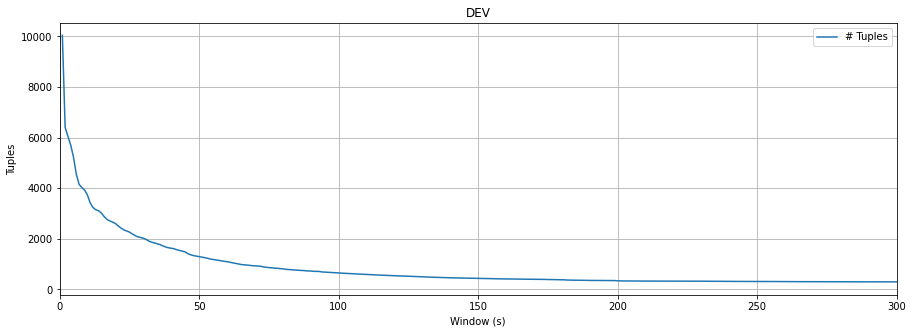

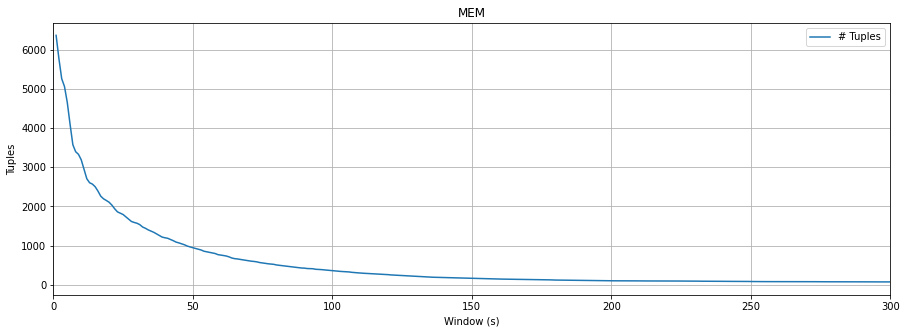

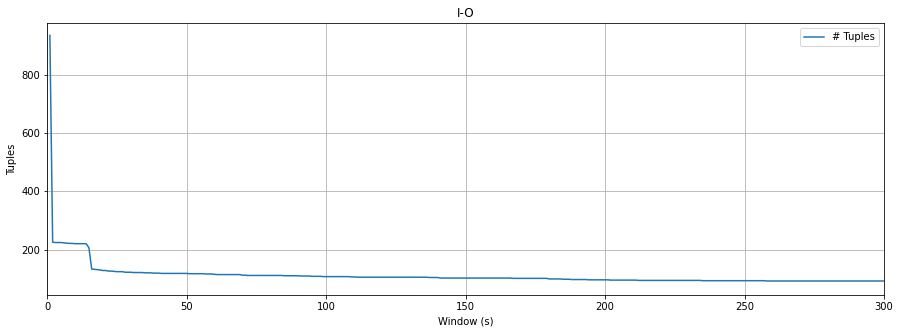

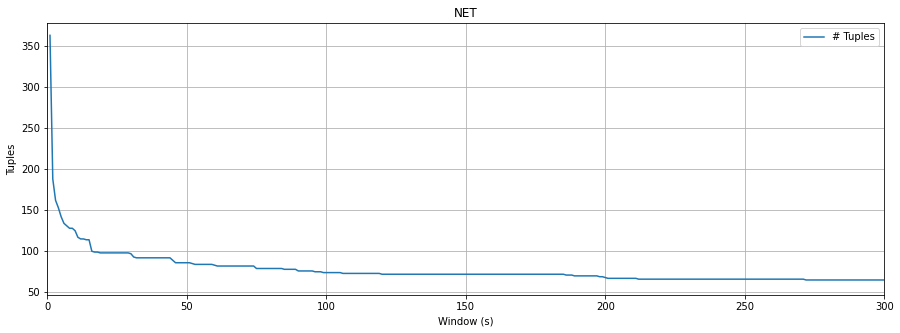

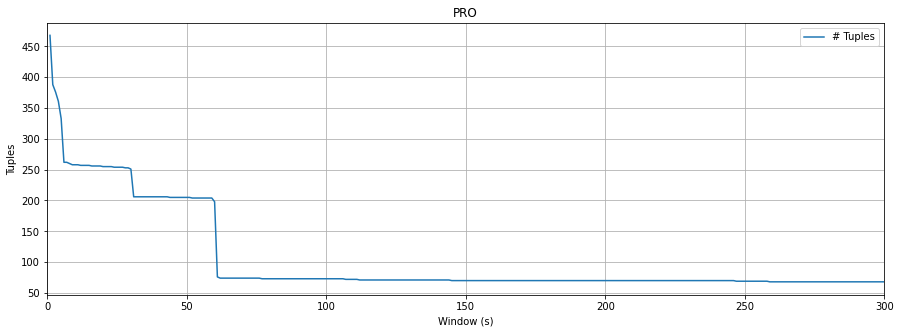

In [47]:
x_dict = {'DEV' : 300,
          'MEM' : 300,
          'I-O' : 300,
          'NET' : 300,
          'PRO' : 300}

for subsys in categories.index:
    filepath = 'Dataset/Mercury-' + subsys + '-Sensitivity.txt'
    df_temp_sensitivity = pd.read_csv(filepath, sep = ' ', names = ['Window', 'Tuples'])
    
    x = df_temp_sensitivity['Window']
    y = df_temp_sensitivity['Tuples']
    
    
    plt.figure(figsize=(15,5))
    plt.plot(x, y, label = '# Tuples')
    plt.title(subsys)
    plt.xlim(0,x_dict[subsys])
#     plt.xticks(np.arange(0, 2000, step = 50))
    plt.xlabel('Window (s)')
    plt.ylabel('Tuples')
    plt.legend()
    plt.grid()

In [ ]:
win_dict = {'DEV' : 500,
          'MEM' : 500,
          'I-O' : 500,
          'NET' : 500,
          'PRO' : 500}

print('Selected colalescence windows:', win_dict)

### Tupling

In [ ]:
dict_df_stat = {}
dict_num_tup = {}

for subsys in categories.index:
    df_temp = df_mercury.loc[df_mercury['Subsystem'] == subsys]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = 'Dataset/Mercury-' + subsys + '-Data.txt'
    df_tupling = tupling(df_temp, win_dict[subsys], filepath)
    num_tup = df_tupling.max(axis = 0).loc['Tuple'] + 1
    dict_num_tup[subsys] = num_tup
    
    df_stat = statistics(df_tupling)
    dict_df_stat[subsys] = df_stat

In [ ]:
print('Number of tuples:', dict_num_tup)

### Empirical reliability

In [ ]:
# top_2 = [k for k in dict_num_tup if dict_num_tup[k] > 30]
# for node in top_2:
    
#     ecdf = ECDF(dict_df_stat[node]['Interarrival'].dropna())

#     plt.figure(figsize=(15,5))
    
#     plt.plot(ecdf.x, 1-ecdf.y, label = 'Empirical Reliability')
#     plt.plot(ecdf.x, ecdf.y, label = 'Empirical CDF')
#     plt.title(node)

#     plt.xlabel('Time (s)')
#     plt.ylabel('Probability')
#     plt.legend()
#     plt.grid()